# Solución etapa 3 - FE + Training

In [176]:
from tabulate import tabulate

def tabl(df):
    print(tabulate(df.head(),headers='keys'))
    print(df.shape)

In [177]:
# Formato de los prints
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


def headr(text):
    return ('\n'+color.UNDERLINE + text + color.END+'\n')


def titl(text):
    return ('\n'+color.BOLD+color.UNDERLINE+color.BLUE + "** " + text.upper() + " **" + color.END+'\n')

In [178]:
# Cargar los datasets
import pandas as pd

historicos_ordenes_cleaned = pd.read_csv('../data/historicos_ordenes_cleaned.csv')
registros_condiciones_cleaned = pd.read_csv('../data/registros_condiciones_cleaned.csv')
caracteristicas_equipos_cleaned = pd.read_csv('../data/caracteristicas_equipos_cleaned.csv')


## Feature eng

### Target

In [179]:
# Generar target

target_column="Fallo"

def code_target(val):
    if val == 'Correctivo':
        return 1
    else:
        return 0


historicos_ordenes_cleaned[target_column] = historicos_ordenes_cleaned["Tipo_Mantenimiento"].apply(code_target)
historicos_ordenes_cleaned.drop("Tipo_Mantenimiento", axis=1, inplace=True)

### historicos_ordenes

In [180]:
tabl(historicos_ordenes_cleaned)

      ID_Orden    ID_Equipo  Fecha                  Costo_Mantenimiento    Duracion_Horas  Ubicacion       Fallo
--  ----------  -----------  -------------------  ---------------------  ----------------  ------------  -------
 0           1           36  2020-01-01 00:00:00                6754.12                 3  Planta Norte        0
 1           2          244  2020-01-01 01:00:00                4274.63                35  Planta Norte        0
 2           3          297  2020-01-01 02:00:00                5752                   25  Planta Norte        0
 3           4          431  2020-01-01 03:00:00                5690.14                 8  Planta Sur          1
 4           5          403  2020-01-01 04:00:00                7048.79                28  Planta Norte        1
(9951, 7)


In [181]:
historicos_ordenes_cleaned['Fecha'] = pd.to_datetime(historicos_ordenes_cleaned['Fecha'])

historicos_ordenes_cleaned['Año'] = historicos_ordenes_cleaned['Fecha'].dt.year
historicos_ordenes_cleaned['Mes'] = historicos_ordenes_cleaned['Fecha'].dt.month
historicos_ordenes_cleaned['Día'] = historicos_ordenes_cleaned['Fecha'].dt.day

tabl(historicos_ordenes_cleaned)

      ID_Orden    ID_Equipo  Fecha                  Costo_Mantenimiento    Duracion_Horas  Ubicacion       Fallo    Año    Mes    Día
--  ----------  -----------  -------------------  ---------------------  ----------------  ------------  -------  -----  -----  -----
 0           1           36  2020-01-01 00:00:00                6754.12                 3  Planta Norte        0   2020      1      1
 1           2          244  2020-01-01 01:00:00                4274.63                35  Planta Norte        0   2020      1      1
 2           3          297  2020-01-01 02:00:00                5752                   25  Planta Norte        0   2020      1      1
 3           4          431  2020-01-01 03:00:00                5690.14                 8  Planta Sur          1   2020      1      1
 4           5          403  2020-01-01 04:00:00                7048.79                28  Planta Norte        1   2020      1      1
(9951, 10)


In [182]:
# Tiempo medio entre fallos por fecha

# Filtrar solo los registros con fallos
fallos = historicos_ordenes_cleaned[historicos_ordenes_cleaned['Fallo'] == 1].copy()

# Ordenar por fecha
fallos = fallos.sort_values(by=['ID_Equipo', 'Fecha'])

# Calcular los intervalos entre fallos consecutivos
fallos['Intervalo'] = fallos.groupby('ID_Equipo')['Fecha'].diff()
fallos['Intervalo_Horas'] = fallos['Intervalo'].dt.total_seconds() / 3600

# Calcular el Tiempo medio entre fallos por equipo
mtbf_por_idequipo = fallos.groupby('ID_Equipo')['Intervalo_Horas'].mean().reset_index()
mtbf_por_idequipo.rename(columns={'Intervalo_Horas': 'Tiempo_medio_entre_fallos(h)'}, inplace=True)

tabl(mtbf_por_idequipo)

      ID_Equipo    Tiempo_medio_entre_fallos(h)
--  -----------  ------------------------------
 0            1                        1164
 1            2                         667.462
 2            3                         984.167
 3            4                        1300.43
 4            5                        1341.71
(499, 2)


In [183]:
# Mezclar historicos_ordenes_cleaned + mtbf_por_idequipo

historicos_mtbf = pd.merge(historicos_ordenes_cleaned, mtbf_por_idequipo, on=['ID_Equipo'], how='left')
tabl(historicos_mtbf)

      ID_Orden    ID_Equipo  Fecha                  Costo_Mantenimiento    Duracion_Horas  Ubicacion       Fallo    Año    Mes    Día    Tiempo_medio_entre_fallos(h)
--  ----------  -----------  -------------------  ---------------------  ----------------  ------------  -------  -----  -----  -----  ------------------------------
 0           1           36  2020-01-01 00:00:00                6754.12                 3  Planta Norte        0   2020      1      1                        1220.12
 1           2          244  2020-01-01 01:00:00                4274.63                35  Planta Norte        0   2020      1      1                         772.5
 2           3          297  2020-01-01 02:00:00                5752                   25  Planta Norte        0   2020      1      1                         752
 3           4          431  2020-01-01 03:00:00                5690.14                 8  Planta Sur          1   2020      1      1                         699.077
 4         

In [184]:
# Tiempo medio entre fallos por mes

# Filtrar solo los registros con fallos
fallos = historicos_ordenes_cleaned[historicos_ordenes_cleaned['Fallo'] == 1].copy()

# Ordenar por fecha
fallos = fallos.sort_values(by=['ID_Equipo', 'Fecha'])

fallos['Diferencia_Horas'] = fallos.groupby('ID_Equipo')['Fecha'].diff().dt.total_seconds() / 3600

promedio_horas_entre_fallos_por_mes = (
    fallos.groupby(['ID_Equipo', 'Año', 'Mes','Día'])['Diferencia_Horas']
          .mean()
          .reset_index(name='Promedio_Horas_Entre_Fallos_por_mes')
)

tabl(promedio_horas_entre_fallos_por_mes)

      ID_Equipo    Año    Mes    Día    Promedio_Horas_Entre_Fallos_por_mes
--  -----------  -----  -----  -----  -------------------------------------
 0            1   2020      2      4                                    nan
 1            1   2020      2     25                                    507
 2            1   2020      3     17                                    492
 3            1   2020      6     12                                   2100
 4            1   2020      7     26                                   1034
(4895, 5)


In [185]:
# Mezclar historicos_ordenes_cleaned + promedio_horas_entre_fallos_por_mes

historicos_promedio_horas_entre_fallos_por_mes = pd.merge(historicos_ordenes_cleaned, promedio_horas_entre_fallos_por_mes, on=['ID_Equipo','Año','Mes','Día'], how='inner')
tabl(historicos_promedio_horas_entre_fallos_por_mes)

      ID_Orden    ID_Equipo  Fecha                  Costo_Mantenimiento    Duracion_Horas  Ubicacion       Fallo    Año    Mes    Día    Promedio_Horas_Entre_Fallos_por_mes
--  ----------  -----------  -------------------  ---------------------  ----------------  ------------  -------  -----  -----  -----  -------------------------------------
 0           4          431  2020-01-01 03:00:00                5690.14                 8  Planta Sur          1   2020      1      1                                    nan
 1           5          403  2020-01-01 04:00:00                7048.79                28  Planta Norte        1   2020      1      1                                    nan
 2           6          477  2020-01-01 05:00:00                1519.65                40  Planta Norte        1   2020      1      1                                    nan
 3           7          323  2020-01-01 06:00:00                9148.27                37  Planta Sur          1   2020      1      1  

In [186]:
# Verificamos nulos
print(historicos_promedio_horas_entre_fallos_por_mes.isna().sum())
historicos_promedio_horas_entre_fallos_por_mes.dropna(inplace=True)

ID_Orden                                 0
ID_Equipo                                0
Fecha                                    0
Costo_Mantenimiento                      0
Duracion_Horas                           0
Ubicacion                                0
Fallo                                    0
Año                                      0
Mes                                      0
Día                                      0
Promedio_Horas_Entre_Fallos_por_mes    507
dtype: int64


In [187]:
# Eliminar columnas sin valor de historicos_mtbf
historicos_mtbf_clean = historicos_mtbf.drop(columns=['ID_Orden','Costo_Mantenimiento','Duracion_Horas','Fecha'])
tabl(historicos_mtbf_clean)

      ID_Equipo  Ubicacion       Fallo    Año    Mes    Día    Tiempo_medio_entre_fallos(h)
--  -----------  ------------  -------  -----  -----  -----  ------------------------------
 0           36  Planta Norte        0   2020      1      1                        1220.12
 1          244  Planta Norte        0   2020      1      1                         772.5
 2          297  Planta Norte        0   2020      1      1                         752
 3          431  Planta Sur          1   2020      1      1                         699.077
 4          403  Planta Norte        1   2020      1      1                        1368.86
(9951, 7)


In [188]:
# Eliminar columnas sin valor de historicos_promedio_horas_entre_fallos_por_mes
historicos_hefbm_clean = historicos_promedio_horas_entre_fallos_por_mes.drop(columns=['ID_Orden','Costo_Mantenimiento','Duracion_Horas','Fecha'])
tabl(historicos_hefbm_clean)

      ID_Equipo  Ubicacion       Fallo    Año    Mes    Día    Promedio_Horas_Entre_Fallos_por_mes
--  -----------  ------------  -------  -----  -----  -----  -------------------------------------
39          161  Planta Sur          1   2020      1      4                                     37
44          286  Planta Este         1   2020      1      4                                     83
47           49  Planta Norte        1   2020      1      5                                      5
49           49  Planta Sur          1   2020      1      5                                      5
68          185  Planta Este         1   2020      1      6                                     90
(4569, 7)


In [189]:
historicos_hefbm_clean.groupby(['ID_Equipo','Año','Mes']).count().loc[1]

Ubicacion  Fallo  Día  Promedio_Horas_Entre_Fallos_por_mes
Año  Mes                                                            
2020 2            1      1    1                                    1
     3            1      1    1                                    1
     6            1      1    1                                    1
     7            1      1    1                                    1
     8            1      1    1                                    1
     12           1      1    1                                    1
2021 1            1      1    1                                    1

> Coincidencia a nivel de mes entre historico y registro

### registros_condiciones

In [190]:
registros_condiciones_cleaned.drop(columns=['ID_Registro'], index=1, inplace=True)

registros_condiciones_cleaned['Fecha']=pd.to_datetime(registros_condiciones_cleaned['Fecha'])
registros_condiciones_cleaned['Año'] = registros_condiciones_cleaned['Fecha'].dt.year
registros_condiciones_cleaned['Mes'] = registros_condiciones_cleaned['Fecha'].dt.month
registros_condiciones_cleaned['Día'] = registros_condiciones_cleaned['Fecha'].dt.day

tabl(registros_condiciones_cleaned)

      ID_Equipo  Fecha                  Temperatura_C    Vibracion_mm_s    Horas_Operativas    Año    Mes    Día
--  -----------  -------------------  ---------------  ----------------  ------------------  -----  -----  -----
 0          260  2020-01-01 00:00:00           101.43              1.22               71849   2020      1      1
 2          443  2020-01-01 02:00:00            76.04              2.93               33106   2020      1      1
 3          281  2020-01-01 03:00:00            97.09              3.25               31744   2020      1      1
 4          427  2020-01-01 04:00:00           139.42              4.22               78104   2020      1      1
 5           48  2020-01-01 05:00:00            98.77              2.73               89664   2020      1      1
(8999, 8)


In [191]:
registros_condiciones_cleaned.groupby(['ID_Equipo','Año','Mes']).count().loc[1]

Fecha  Temperatura_C  Vibracion_mm_s  Horas_Operativas  Día
Año  Mes                                                             
2020 1        2              2               2                 2    2
     3        2              2               2                 2    2
     4        3              3               3                 3    3
     6        1              1               1                 1    1
     7        2              2               2                 2    2
     8        2              2               2                 2    2
     10       1              1               1                 1    1
     12       2              2               2                 2    2

In [192]:
# Agrupar por 'ID_Equipo', 'Año' y 'Mes', y calcular los promedios
promedios_por_equipo_mes = (
    registros_condiciones_cleaned.groupby(['ID_Equipo', 'Año', 'Mes','Día'])[['Temperatura_C', 'Vibracion_mm_s', 'Horas_Operativas']]
      .mean()
      .reset_index()
)

# Renombrar las columnas para claridad
promedios_por_equipo_mes.rename(columns={
    'Temperatura_C': 'Promedio_Temperatura_C',
    'Vibracion_mm_s': 'Promedio_Vibracion_mm_s',
    'Horas_Operativas': 'Promedio_Horas_Operativas'
}, inplace=True)

tabl(promedios_por_equipo_mes)

      ID_Equipo    Año    Mes    Día    Promedio_Temperatura_C    Promedio_Vibracion_mm_s    Promedio_Horas_Operativas
--  -----------  -----  -----  -----  ------------------------  -------------------------  ---------------------------
 0            1   2020      1      2                     93.8                        0.7                         80054
 1            1   2020      1     21                    102.99                       2.31                        74797
 2            1   2020      3      2                    145.97                       1.57                        95240
 3            1   2020      3     16                    147.18                       2.49                         6872
 4            1   2020      4     17                     58.93                       3.54                        28186
(8793, 7)


In [193]:
promedios_por_equipo_mes.isna().sum()
promedios_por_equipo_mes.dropna(inplace=True)
promedios_por_equipo_mes.shape

(8755, 7)

### Unir merged_hitorico_registro + promedios + caracteristicas

In [194]:
# Unir datasets
final_data = pd.merge(historicos_hefbm_clean, promedios_por_equipo_mes, on=['ID_Equipo','Año','Mes'], how='inner')
final_data = pd.merge(final_data, caracteristicas_equipos_cleaned, on='ID_Equipo', how='inner')

tabl(final_data)

      ID_Equipo  Ubicacion       Fallo    Año    Mes    Día_x    Promedio_Horas_Entre_Fallos_por_mes    Día_y    Promedio_Temperatura_C    Promedio_Vibracion_mm_s    Promedio_Horas_Operativas  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Recomendadas_Revision
--  -----------  ------------  -------  -----  -----  -------  -------------------------------------  -------  ------------------------  -------------------------  ---------------------------  -------------  ------------  --------  -------------  -----------------------------
 0          161  Planta Sur          1   2020      1        4                                     37       31                    103.35                       3.9                         37071  Motor          ABB           Z300               1706                           4455
 1          286  Planta Este         1   2020      1        4                                     83       29                     57.58                       3.65       

### Limpiar columnas accesorias

In [195]:
final_data.drop(columns=['ID_Equipo','Año', 'Mes', 'Día_x', 'Día_y'], inplace=True)

tabl(final_data)

    Ubicacion       Fallo    Promedio_Horas_Entre_Fallos_por_mes    Promedio_Temperatura_C    Promedio_Vibracion_mm_s    Promedio_Horas_Operativas  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Recomendadas_Revision
--  ------------  -------  -------------------------------------  ------------------------  -------------------------  ---------------------------  -------------  ------------  --------  -------------  -----------------------------
 0  Planta Sur          1                                     37                    103.35                       3.9                         37071  Motor          ABB           Z300               1706                           4455
 1  Planta Este         1                                     83                     57.58                       3.65                          250  Generador      GE            Y200               3432                           8213
 2  Planta Norte        1                                      5        

### Duplicados

In [196]:
# Eliminar duplicados

print(headr('Duplicados final_data:'),final_data.duplicated().sum())
# final_data.drop_duplicates(inplace=True)
# tabl(final_data)


Duplicados final_data:
 15


In [197]:
# Verificamos nulos
print(headr('Nulos final_data:'),final_data.isna().sum())


Nulos final_data:
 Ubicacion                              0
Fallo                                  0
Promedio_Horas_Entre_Fallos_por_mes    0
Promedio_Temperatura_C                 0
Promedio_Vibracion_mm_s                0
Promedio_Horas_Operativas              0
Tipo_Equipo                            0
Fabricante                             0
Modelo                                 0
Potencia_kW                            0
Horas_Recomendadas_Revision            0
dtype: int64


In [198]:
columnas_con_nulos = final_data.columns[final_data.isna().any()].tolist()
columnas_con_nulos

[]

In [199]:
# Imputamos nulos
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# final_data[columnas_con_nulos] = imputer.fit_transform(final_data[columnas_con_nulos])

In [200]:
tabl(final_data)

    Ubicacion       Fallo    Promedio_Horas_Entre_Fallos_por_mes    Promedio_Temperatura_C    Promedio_Vibracion_mm_s    Promedio_Horas_Operativas  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Recomendadas_Revision
--  ------------  -------  -------------------------------------  ------------------------  -------------------------  ---------------------------  -------------  ------------  --------  -------------  -----------------------------
 0  Planta Sur          1                                     37                    103.35                       3.9                         37071  Motor          ABB           Z300               1706                           4455
 1  Planta Este         1                                     83                     57.58                       3.65                          250  Generador      GE            Y200               3432                           8213
 2  Planta Norte        1                                      5        

In [201]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5686 entries, 0 to 5685
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Ubicacion                            5686 non-null   object 
 1   Fallo                                5686 non-null   int64  
 2   Promedio_Horas_Entre_Fallos_por_mes  5686 non-null   float64
 3   Promedio_Temperatura_C               5686 non-null   float64
 4   Promedio_Vibracion_mm_s              5686 non-null   float64
 5   Promedio_Horas_Operativas            5686 non-null   float64
 6   Tipo_Equipo                          5686 non-null   object 
 7   Fabricante                           5686 non-null   object 
 8   Modelo                               5686 non-null   object 
 9   Potencia_kW                          5686 non-null   float64
 10  Horas_Recomendadas_Revision          5686 non-null   int64  
dtypes: float64(5), int64(2), objec

### Volvemos a explorar con columnas codificadas


In [202]:
# Extraer columnas numéricas y categóricas
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(final_data)
categorical_columns = categorical_columns_selector(final_data)

print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)


Numerical columns
 ['Fallo', 'Promedio_Horas_Entre_Fallos_por_mes', 'Promedio_Temperatura_C', 'Promedio_Vibracion_mm_s', 'Promedio_Horas_Operativas', 'Potencia_kW', 'Horas_Recomendadas_Revision']

Categorical columns
 ['Ubicacion', 'Tipo_Equipo', 'Fabricante', 'Modelo']


In [203]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

final_data_coded =final_data.copy()
final_data_coded[categorical_columns] =final_data_coded[categorical_columns].apply(LabelEncoder().fit_transform)   
tabl(final_data_coded)

      Ubicacion    Fallo    Promedio_Horas_Entre_Fallos_por_mes    Promedio_Temperatura_C    Promedio_Vibracion_mm_s    Promedio_Horas_Operativas    Tipo_Equipo    Fabricante    Modelo    Potencia_kW    Horas_Recomendadas_Revision
--  -----------  -------  -------------------------------------  ------------------------  -------------------------  ---------------------------  -------------  ------------  --------  -------------  -----------------------------
 0            3        1                                     37                    103.35                       3.9                         37071              2             0         3           1706                           4455
 1            0        1                                     83                     57.58                       3.65                          250              1             1         2           3432                           8213
 2            1        1                                      5             

In [204]:
# Evaluamos la aportación de cada columna
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,chi2

X= final_data_coded.drop(target_column, axis=1)
y = final_data_coded[target_column]

fvalue_selector = SelectKBest(f_classif, k=2)

X_kbest = fvalue_selector.fit(X,y)

feature_scores = pd.DataFrame({"Feature": X.columns,"Score": X_kbest.scores_}).sort_values(by="Score", ascending=False)

print(headr("Feature scores"))
round(feature_scores,2)


Feature scores



,Feature,Score
8,Potencia_kW,8.23
2,Promedio_Temperatura_C,4.36
9,Horas_Recomendadas_Revision,3.94
0,Ubicacion,3.43
5,Tipo_Equipo,2.40
1,Promedio_Horas_Entre_Fallos_por_mes,2.16
6,Fabricante,1.98
3,Promedio_Vibracion_mm_s,1.57
4,Promedio_Horas_Operativas,0.28
7,Modelo,0.00


In [205]:
# Eliminamos columnas sin peso

columns_to_drop = feature_scores[feature_scores['Score'] == 0]['Feature']
final_data.drop(columns=columns_to_drop, inplace=True)
tabl(final_data)

    Ubicacion       Fallo    Promedio_Horas_Entre_Fallos_por_mes    Promedio_Temperatura_C    Promedio_Vibracion_mm_s    Promedio_Horas_Operativas  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Recomendadas_Revision
--  ------------  -------  -------------------------------------  ------------------------  -------------------------  ---------------------------  -------------  ------------  --------  -------------  -----------------------------
 0  Planta Sur          1                                     37                    103.35                       3.9                         37071  Motor          ABB           Z300               1706                           4455
 1  Planta Este         1                                     83                     57.58                       3.65                          250  Generador      GE            Y200               3432                           8213
 2  Planta Norte        1                                      5        

## Preprocesar

In [206]:
# Dividir en variables predictoras (X) y objetivo (y)
X = final_data.drop(columns=['Fallo'])

y = final_data[target_column]

In [207]:
# Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Candidatos

1. LogisticRegression
2. GradientBoostingClassifier
3. SVC (kernel='rbf')

In [208]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

### Pipelines

In [209]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)


print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)


Numerical columns
 ['Promedio_Horas_Entre_Fallos_por_mes', 'Promedio_Temperatura_C', 'Promedio_Vibracion_mm_s', 'Promedio_Horas_Operativas', 'Potencia_kW', 'Horas_Recomendadas_Revision']

Categorical columns
 ['Ubicacion', 'Tipo_Equipo', 'Fabricante', 'Modelo']


In [210]:
# Preprocesamiento para variables categóricas
categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesamiento para variables continuas
numerical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [211]:
pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression())]),
    # "GradientBoostingClassifier": Pipeline([('preprocessor', preprocessor),('classifier', GradientBoostingClassifier())]),
    "SVC": Pipeline([('preprocessor', preprocessor),('classifier', SVC(kernel='linear'))]),
    "SGDClassifier": Pipeline([('preprocessor', preprocessor),('classifier', SGDClassifier())]),
}

### CV

In [212]:
def cv_train(name, pipeline, cv):
    print(headr(f"Entrenar {name}"))
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring="accuracy", return_estimator=True, return_train_score=True, n_jobs=5)
    trained_model = cv_results["estimator"][0]
    scores = pd.DataFrame(cv_results)

    print("test score (mean-std): {0:.2f} - {1:.2f}".format(scores["test_score"].mean(), scores["test_score"].std()))
    print("train score (mean-std): {0:.2f} - {1:.2f}".format(scores["train_score"].mean(), scores["train_score"].std()))
    print("params:", pipeline.named_steps.get("classifier").get_params())

    y_pred = trained_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return {"acc": round(scores["test_score"].mean(), 2), "f1": round(f1, 2),}

In [213]:
# Aplicar CV
cvss = ShuffleSplit(n_splits=40, test_size=0.2, random_state=0)

results = {}

for name, pipeline in pipelines.items():
    results[name] = cv_train(name, pipeline, cvss)

print(titl("Resultados:"))
results_df=pd.DataFrame(results)
results_df


Entrenar LogisticRegression

test score (mean-std): 0.98 - 0.00
train score (mean-std): 0.98 - 0.00
params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Entrenar SVC

test score (mean-std): 0.98 - 0.00
train score (mean-std): 0.98 - 0.00
params: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Entrenar SGDClassifier

test score (mean-std): 0.98 - 0.00
train score (mean-std): 0.98 - 0.00
params: {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept'

,LogisticRegression,SVC,SGDClassifier
acc,0.98,0.98,0.98
f1,0.99,0.99,0.99


### Curva de aprendizaje


In [214]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve

%matplotlib inline

In [215]:
# Curvas de aprendizaje

train_sizes = np.linspace(0.5, 1.0, num=5, endpoint=True)

def generate_learning_curves(name, pipeline, X, y, train_sizes):
    results = learning_curve(pipeline, X, y, train_sizes=train_sizes,
                             cv=cvss, scoring='accuracy', n_jobs=5)
    
    train_size, train_scores, test_scores = results[:3]

    # graficar la curva.
    plt.errorbar(train_size, train_scores.mean(axis=1),
                 yerr=train_scores.std(axis=1), label="Error de entrenamiento")
    plt.errorbar(train_size, test_scores.mean(axis=1),
                 yerr=test_scores.std(axis=1), label="Error de prueba")
    plt.legend()

    plt.xscale("log")
    plt.xlabel("Número de muestras en el conjunto de entrenamiento")
    plt.ylabel("Accuracy")
    plt.title("Curva de aprendizaje para {name}".format(name=name))

    plt.show()

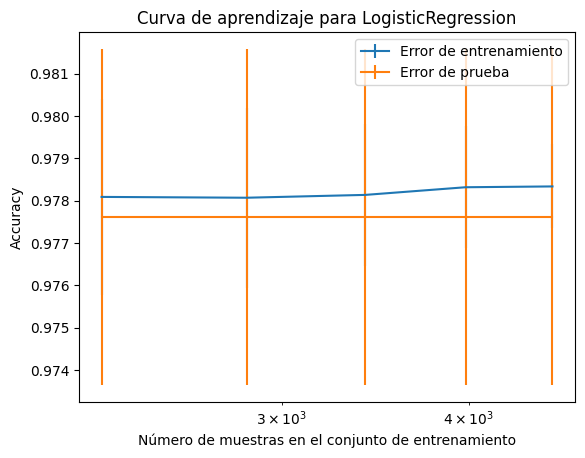

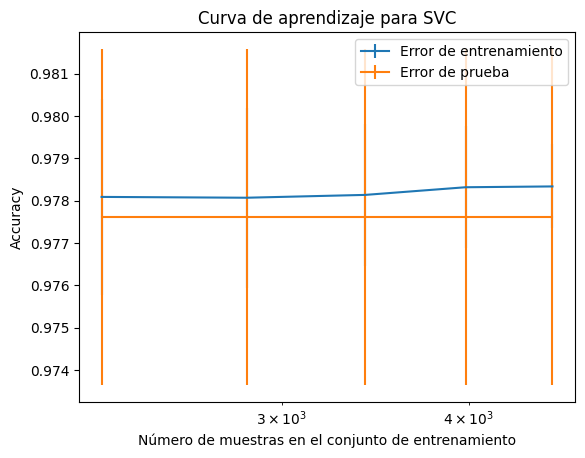

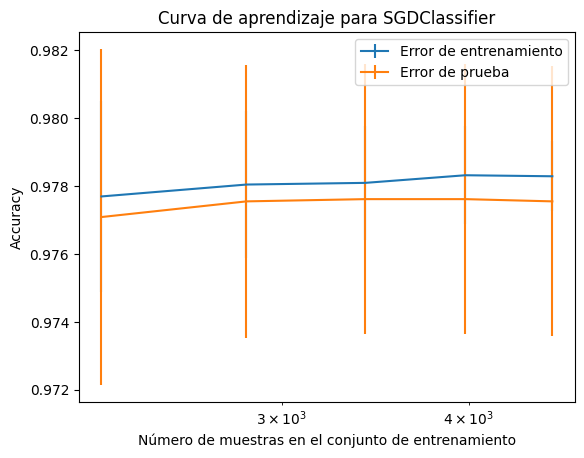

In [216]:
# Aplicar LC
for pipeline_name, pipeline_obj in pipelines.items():
    generate_learning_curves(pipeline_name, pipeline_obj, X, y, train_sizes)